In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os

In [29]:
os.chdir('input/data')
os.getcwd()

'/opt/ml/input/data'

In [30]:
!find . -regex ".*\.\_[a-zA-Z0-9._]+" -delete

In [2]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
train_dir_path = '/opt/ml/input/data/train/'
train_image_path = '/opt/ml/input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
dt_train

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [4]:
whole_image_path = []
whole_target_label = []

for path in dt_train['path']:
    for file_name in [i for i in os.listdir(train_image_path+path) if './' not in i]:
        whole_image_path.append(train_image_path+path+'/'+file_name)
        whole_target_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))

In [5]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [6]:
sr_data = pd.Series(whole_image_path)
sr_label = pd.Series(whole_target_label)

In [8]:
class Dataset_Mask(Dataset):
    def __init__(self, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = sr_data
        self.label = sr_label
        self.transform = transform
        
        if encoding:
            self.label = self.label.apply(onehot_enc)
        
    def __len__(self):
        return len(sr_data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.midcrop:
            X = X[64:448]
        
        if self.transform:
            return self.transform(X), y
        return X, y

In [9]:
dataset_mask = Dataset_Mask(transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [10]:
train_size = int(len(dataset_mask) * 0.8)
val_size = int(len(dataset_mask) * 0.2)

In [11]:
mask_train_set, mask_val_set = torch.utils.data.random_split(dataset_mask, [train_size, val_size])
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 15120
validation data size : 3780


In [12]:
batch_size = 256
train_dataloader_mask = DataLoader(dataset = mask_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
basemodel_resnet34 = torchvision.models.resnet34(pretrained=True)
print('필요 입력 채널 개수', basemodel_resnet34.conv1.weight.shape[1])
print('네트워크 출력 채널 개수', basemodel_resnet34.fc.weight.shape[0])
print(basemodel_resnet34)

필요 입력 채널 개수 3
네트워크 출력 채널 개수 1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
import math
class_num = 18
basemodel_resnet34.fc = nn.Linear(in_features=512, out_features=class_num, bias=True)
nn.init.xavier_uniform_(basemodel_resnet34.fc.weight)
stdv = 1. / math.sqrt(basemodel_resnet34.fc.weight.size(1))
basemodel_resnet34.fc.bias.data.uniform_(-stdv, stdv)

print('필요 입력 채널 개수', basemodel_resnet34.conv1.weight.shape[1])
print('네트워크 출력 채널 개수', basemodel_resnet34.fc.weight.shape[0])

필요 입력 채널 개수 3
네트워크 출력 채널 개수 18


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

basemodel_resnet34.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basemodel_resnet34.parameters(), lr=LEARNING_RATE)

using cuda:0


In [16]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(basemodel_resnet34.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[conv1.weight] shape:[(64, 3, 7, 7)].
    val:[ 0.005 -0.007  0.008  0.038  0.049]
[1] name:[bn1.weight] shape:[(64,)].
    val:[0.302 0.268 0.26  0.311 0.238]
[2] name:[bn1.bias] shape:[(64,)].
    val:[0.481 0.207 0.331 0.38  0.094]
[3] name:[layer1.0.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[-0.005  0.015 -0.006 -0.06  -0.024]
[4] name:[layer1.0.bn1.weight] shape:[(64,)].
    val:[0.24  0.185 0.216 0.165 0.181]
[5] name:[layer1.0.bn1.bias] shape:[(64,)].
    val:[0.025 0.088 0.082 0.142 0.066]
[6] name:[layer1.0.conv2.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.066 -0.01   0.041  0.033 -0.055]
[7] name:[layer1.0.bn2.weight] shape:[(64,)].
    val:[0.34  0.187 0.252 0.307 0.259]
[8] name:[layer1.0.bn2.bias] shape:[(64,)].
    val:[-0.251  0.196  0.23  -0.114  0.07 ]
[9] name:[layer1.1.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[-0.008 -0.04  -0.054 -0.019  0.011]
[10] name:[layer1.1.bn1.weight] shape:[(64,)].
    val:[0.178 0.373 0.18  0.26  0.246]
[11] name:[layer1.

In [17]:
best_val_acc = 0
best_val_loss = np.inf

for epoch in range(NUM_EPOCH):
    basemodel_resnet34.train()
    loss_value = 0
    matches = 0
    for train_batch in train_dataloader_mask:
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = basemodel_resnet34(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        
        train_loss = loss_value / batch_size
        train_acc = matches / batch_size
        print(f"epoch[{epoch}/{NUM_EPOCH}] training loss {train_loss:.3f}, training accuracy {train_acc:.3f}")
        
        loss_value = 0
        matches = 0
        
    with torch.no_grad():
        basemodel_resnet34.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_dataloader_mask:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = basemodel_resnet34(inputs)
            preds = torch.argmax(outs, dim=-1)
            
            loss_item = criterion(outs, labels).item()
            acc_item = (labels==preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            
        val_loss = np.sum(val_loss_items) / len(val_dataloader_mask)
        val_acc = np.sum(val_acc_items) / len(mask_val_set)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
        print(f"[val] acc : {val_acc:.3f}, loss : {val_loss:.3f}")
        print(f"best acc : {best_val_acc:.3f}, best loss : {best_val_loss:.3f}")

epoch[0/30] training loss 0.015, training accuracy 0.035
epoch[0/30] training loss 0.012, training accuracy 0.156
epoch[0/30] training loss 0.009, training accuracy 0.312
epoch[0/30] training loss 0.008, training accuracy 0.449
epoch[0/30] training loss 0.006, training accuracy 0.551
epoch[0/30] training loss 0.006, training accuracy 0.648
epoch[0/30] training loss 0.005, training accuracy 0.652
epoch[0/30] training loss 0.004, training accuracy 0.746
epoch[0/30] training loss 0.004, training accuracy 0.754
epoch[0/30] training loss 0.004, training accuracy 0.758
epoch[0/30] training loss 0.003, training accuracy 0.812
epoch[0/30] training loss 0.004, training accuracy 0.762
epoch[0/30] training loss 0.003, training accuracy 0.785
epoch[0/30] training loss 0.003, training accuracy 0.836
epoch[0/30] training loss 0.003, training accuracy 0.805
epoch[0/30] training loss 0.002, training accuracy 0.828
epoch[0/30] training loss 0.002, training accuracy 0.887
epoch[0/30] training loss 0.002

KeyboardInterrupt: 

In [19]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir_path = '/opt/ml/input/data/eval/'
test_image_path = '/opt/ml/input/data/eval/images/'

submission = pd.read_csv(test_dir_path+'info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [20]:
image_paths = [os.path.join(test_image_path, img_id) for img_id in submission.ImageID]
test_image = pd.Series(image_paths)

In [21]:
class Test_Dataset(Dataset):
    def __init__(self, midcrop=True, transform=None):
        self.midcrop = midcrop
        self.data = test_image
        self.transform = transform
        
    def __len__(self):
        return len(test_image)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        
        if self.midcrop:
            img = img[64:448]
            
        if self.transform:
            img = self.transform(img)
            
        return img

In [22]:
dataset = Test_Dataset(transform = transforms.Compose([
                            transforms.ToTensor()
                        ]))

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = basemodel_resnet34.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir_path, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


2a14fa2df7444c78da933f65120d165ed6f66b8a.jpg


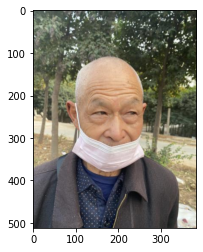

In [49]:
ID = submission['ImageID'][372]
img = cv2.cvtColor(cv2.imread(test_image_path + ID), cv2.COLOR_BGR2RGB)
print(ID)
plt.imshow(img)